# Convolutional Neural Network - Colon Cancer Classifier

In this Project I will use an open dataset from Kaggle of colon histopathology slide images. This CNN classifier will predict if a the histopathology images is benign or malignant. The data set consist of over 10000 images, made out of 500 histopathology slides(250 benign colon tissue and 250 colon cancerous tissue).

I will be using the following workflow to create this model:
- 9600 Images will be used in total
- 1536 images will be used for in-training cross validation
- 1920 Images will be reserved for the final test set
- 6144 images will be used for direct training
- There will be a 20% cross-validation during training and a seperate 20% test set
- 400 Images(200 benign and 200 malignant) have been extracted from the dataset and kept completely seperate for online testing purposes
- Load malign/benign images and their corresponding labels
- Shuffle all images
- Split images into a training and test set
- Define two classes: 1 = malign / 0 = benign
- Apply a CNN to train the network
- Use accuracy to measure the model results
- Save the model

Original dataset is available on https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign/code

### Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import os
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import numpy as np
#from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import accuracy_score

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


###  Setting Initial Variables

In [4]:
RANDOM_STATE = 98

# Define the image directory:
# alternaive test path: data_experiment/train/benign/     and     data_experiment/train/malignant/
IMAGE_DIR_BENIGN = './colon_data/colon_image_sets/colon_n/'
IMAGE_DIR_MALIGNANT = './colon_data/colon_image_sets/colon_aca/'

#Our model will use a total of 9600 images
NUM_TRAIN_IMAGES_BEN = 4800
NUM_TRAIN_IMAGES_MAL = 4800

In [5]:
tumor_classes = 2

In [6]:
# Input image dimensions are a 120 x 120 Matrix and 3 channels(RGB colors)
first_input = (120,120,3)

### Create Features and Labels

#### I. Exract the Images

I will extract images in this section using a custom made method

In [7]:
def extract_images(image_directory: str, length_array:int):
    ''' This function returns a list of images'''
    image_dir=os.listdir(image_directory)
    show_list = []
    for img,i in zip(image_dir,range(length_array)):
        if img != '.DS_Store':
            ext_img = image.load_img(str(image_directory+img), target_size=(120, 120))
            show_list.append(ext_img)
    #show_img = ext_img
    return show_list

In [8]:
# Extract two arrays of images, benign and malignant:
benign_images = extract_images(IMAGE_DIR_BENIGN ,NUM_TRAIN_IMAGES_BEN)
malignant_images = extract_images(IMAGE_DIR_MALIGNANT,NUM_TRAIN_IMAGES_MAL)

In [9]:
# Check the size of each array:
len(benign_images), len(malignant_images)

(4800, 4800)

In [10]:
def show_samples():
    for i in range(1,4):
        plt.subplot(1, 3, i)
        plt.imshow(malignant_images[i])

This is an example of malignant histopathology slides of colorectal cancer:

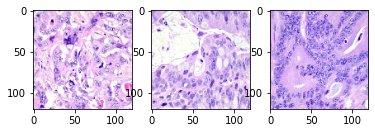

In [11]:
show_samples()

#### II. Create Final Features X and y

In [12]:
# Create X_malignant
def create_feature_label_array(image_list):
    '''Return a numpy array of all images'''
    feature_images= []
    for image in image_list:
        data = np.asarray( image )
        feature_images.append(data)

    feature_images = np.array(feature_images)
    return feature_images

In [13]:

X_malignant = create_feature_label_array(malignant_images)

# Create labels where each malignant image is labeled as 1
y_malignant = np.ones(len(X_malignant))

# Show the shapes of the features and labels
X_malignant.shape, y_malignant.shape

((4800, 120, 120, 3), (4800,))

In [14]:
X_benign = create_feature_label_array(benign_images)

# Create labels where each benign skin leasion is labeled as 0
y_benign = np.zeros(len(X_benign))
X_benign.shape,y_benign.shape

((4800, 120, 120, 3), (4800,))

In [15]:
# Concatenate both malignant and benign features/labels, show their shape
X = np.concatenate((X_malignant,X_benign))
y = np.concatenate((y_malignant,y_benign))

# Scale the images:
X = X/255
# X is a 4D tensor
X.shape,y.shape

((9600, 120, 120, 3), (9600,))

In [16]:
y[0:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### III. Shuffle and Split Into Train and Test

I split the dataset into a train and test set

In [17]:
np_shuffler = np.random.permutation(len(X))
X = X[np_shuffler]
y = y[np_shuffler]

In [18]:
y[0:20]

array([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0.])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [20]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((7680, 120, 120, 3), (1920, 120, 120, 3), (7680,), (1920,))

### Create CNN Model

If we had more than 2 classes then you should one-hot-encode the classes. The output dense layer should be 'softmax' for multiclass classification. Since this project is a binary classifier, I will use the sigmoid activation function.

In [22]:
# Convert class vectors to binary class matrices to feed the model.
# One-hot encode using this:
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [23]:
# Instantiate the InceptionV3 model and drop the top layer
#with tf.device('/CPU:0'):
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=first_input)

In [24]:
total_layers= len(inception_model.layers)

# Freeze layers:
for layer,i in zip(inception_model.layers,range(total_layers - 3)):
    layer.trainable = False

In [25]:
patho_model_main = tf.keras.Sequential([
    inception_model,

    # can be put between every layer
    layers.Flatten(),
        
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),

    # Final output layer, with 1 node and sigmoid activation because we are
    # training a binary classifier:
    layers.Dense(1, activation='sigmoid')
])

In [26]:
batch_size = 20
epochs = 15

In [27]:
patho_model_main.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Epoch 1/15
308/308 [==============================] - 290s 647ms/step - loss: 0.1900 - accuracy: 0.9229 - val_loss: 0.0652 - val_accuracy: 0.9785
Epoch 2/15
308/308 [==============================] - 6s 18ms/step - loss: 0.0844 - accuracy: 0.9697 - val_loss: 0.0568 - val_accuracy: 0.9785
Epoch 3/15
308/308 [==============================] - 6s 18ms/step - loss: 0.0436 - accuracy: 0.9833 - val_loss: 0.0545 - val_accuracy: 0.9811
Epoch 4/15
308/308 [==============================] - 5s 18ms/step - loss: 0.0389 - accuracy: 0.9852 - val_loss: 0.0421 - val_accuracy: 0.9831
Epoch 5/15
308/308 [==============================] - 6s 18ms/step - loss: 0.0404 - accuracy: 0.9842 - val_loss: 0.0346 - val_accuracy: 0.9876
Epoch 6/15
308/308 [==============================] - 6s 18ms/step - loss: 0.0308 - accuracy: 0.9889 - val_loss: 0.0742 - val_accuracy: 0.9792
Epoch 7/15
308/308 [==============================] - 5s 18ms/step - loss: 0.0272 - accuracy: 0.9901 - val_loss: 0.0506 - val_accuracy: 0.9

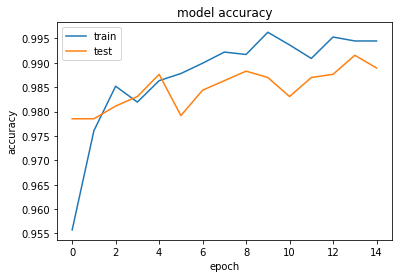

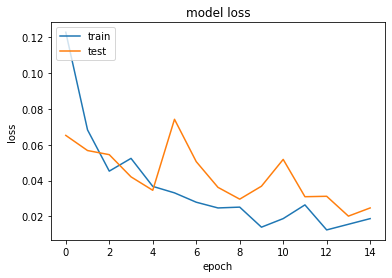

In [28]:
history = patho_model_main.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
patho_model_main.save("colon_CNN_model_main.h5")

### Loading our Saved Model

In [21]:
new_mod = keras.models.load_model("colon_CNN_model_main.h5")


In [22]:
new_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22,064,993
Trainable params: 262,209
Non-trainable params: 21,802,784
_________________________________________________________________


In [36]:
image1 = np.asarray( malignant_images[3] )
image1=image1.reshape(1,120, 120, 3)
image1.shape

#mgt_temp = image.img_to_array(benign_images[22]) 
#mgt_temp = mgt_temp.reshape(1,120, 120, 3)
#new_mod.predict(mgt_temp)
result = new_mod.predict(image1)
print(result)

[[0.]]


In [33]:
from matplotlib import pyplot as plt
from tensorflow.keras import Model

In [34]:
# Show the model layers
new_mod.layers

In [35]:
new_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 22,064,993
Trainable params: 262,209
Non-trainable params: 21,802,784
_________________________________________________________________


### Testing the Model

In the following section I will use the scikit learn accuracy score method to predict how well our model makes prediction on the test set

In [36]:
# Show initial shape
X_test.shape

(1920, 120, 120, 3)

In [29]:
# run the prediction
pred_test= new_mod.predict(X_test)

In [43]:
# Show the first 3 preditions
pred_test[:3]

array([[1.],
       [1.],
       [0.]], dtype=float32)

In [44]:
# Show the first 3 true classifications
y_test[:3]

array([1., 1., 0.])

In [37]:
# Convert pred_test values from probabilities to a binary outpput
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0

In [34]:
pred_test[:3]

array([[1.],
       [1.],
       [0.]], dtype=float32)

In [35]:
#y_val_crosscheck = np.zeros(len(y_test))

accuracy_score(pred_test,y_test)

0.9972222222222222

### Conclusion and Discussion

We trained our model using the Inception V3 model. This yielded an excellent result with an accuracy score of 99%, a cross validation score of 98% and a final test set score of 99%, this speaks for a very well fitting model and reinforces my initial hypethesis that a pre-trained model can still be used accurately on a histopathology dataset.

I kept another 400 images(200 malignant and 200 benign), completely seperate from the training data. I used these images for testing the model after deploying it onto a google cloud instance and attaching a front end website for interactivity. So far I have not received any incorrect results when testing the model online either. 


There are still potential optimization techniques for this model, for example I have not yet tried any dimentionality reduction such as PCA and I have not used any image augmentation. Training a pre-made model amounts to something of a black box. We do not know what criteria the neural network uses to differentiate the pathology features.

I would like to try to train this model on the histopathology of lung cancer, which is also available seperately on Kaggle and perhaps experiment with a completely new model, RNN(which has been used in studies pertaining to computational pathology), to see what results I would get. 